In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
# Loop through and load in artifacts, signal, and do beta wavelet
training_sessions = [['Rey', 'training'],['Han','training'],['Django', 'training'], ['Finn2', 'training'],['Rose', 'training'], ['Jyn','training']]
beta_channels = [26, 8, 59, 7, 25, 18]
beta_range = np.arange(12, 40, 1)
rec_list = []

for (animal, sess_name), beta_channel in zip(training_sessions, beta_channels):
    
    sess_dir = get_session_dir(animal, sess_name)
    sess = sess_use(sess_dir)
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.signal = sess.eegfile.get_signal()
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)
    signal = sess.eegfile.get_signal()
    sess.wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), 
                              freqs=beta_range, sigma=None)
    
    rec_list.append(sess)
rec_list
# print(sess.recinfo)

[ProcessData(Rey_training_denoised.xml),
 ProcessData(Han_training.xml),
 ProcessData(Django_training_denoised.xml),
 ProcessData(Finn2_training_denoised.xml),
 ProcessData(Rose_training_denoised.xml),
 ProcessData(Jyn_training_denoised.xml)]

In [4]:
rec_list

[ProcessData(Rey_training_denoised.xml),
 ProcessData(Han_training.xml),
 ProcessData(Django_training_denoised.xml),
 ProcessData(Finn2_training_denoised.xml),
 ProcessData(Rose_training_denoised.xml),
 ProcessData(Jyn_training_denoised.xml)]

In [5]:
# Import USVs
usv_list = []
for sess in rec_list:
    # Import USV epochs (from Sync_USV_and_Ephys notebook).
    usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
    usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
    usv_list.append(usv_epochs)

In [6]:
beta_range

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

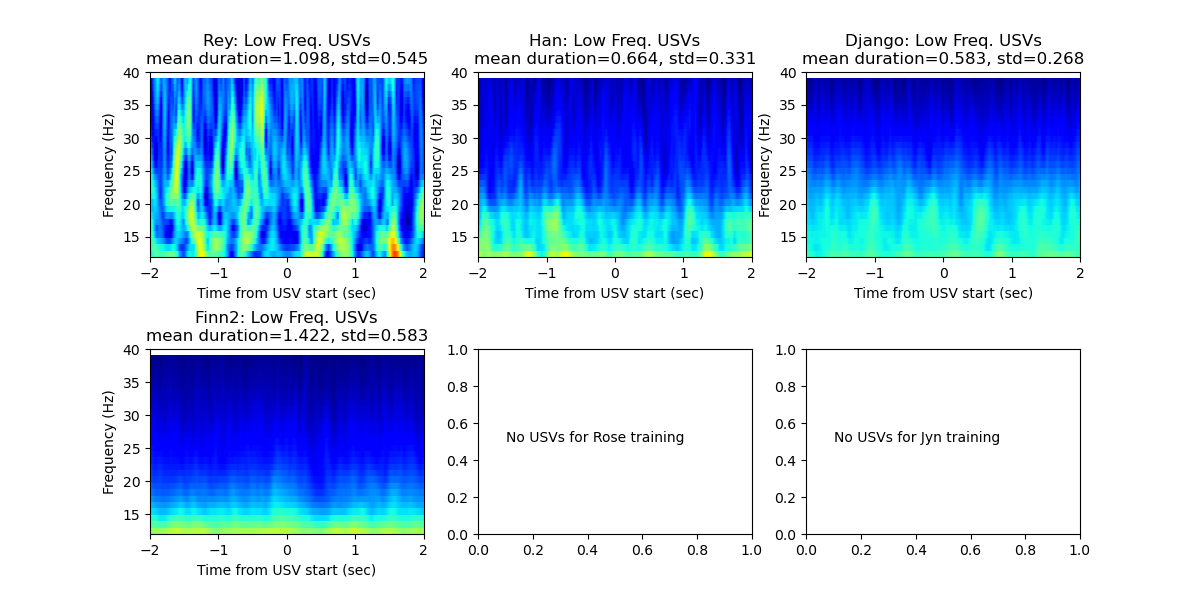

In [25]:
# Plot low USVs onset for all animals
%matplotlib widget
freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (2,2)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(low_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                            ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV start (sec)')
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")
plt.subplots_adjust(hspace=0.5)

In [27]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_low_usv_onset.png')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

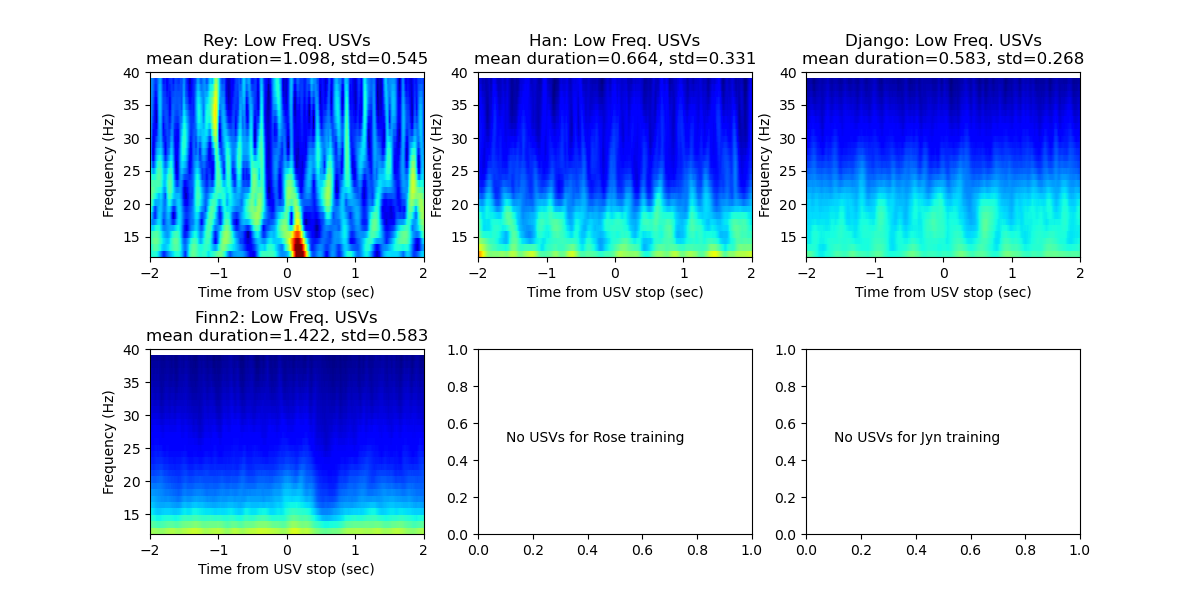

In [28]:
# Plot low USVs offset for all animals
%matplotlib widget
freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (2,2)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(low_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                            ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")
plt.subplots_adjust(hspace=0.5)

In [29]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_low_usv_offset.png')

In [11]:
usv_list

[31 epochs
 Snippet: 
          start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
 0  918.489945  918.545653  454.143559  41.270313  0.058728   12.706250    1.0   
 1  918.830174  918.913128  454.502235  48.738021  0.087452    9.696875    1.0   
 2  919.498451  919.591260  455.206745  39.821354  0.097841   14.378125    1.0   
 3  920.429279  920.545830  456.188042  41.381771  0.122870   12.594792    1.0   
 4  920.954249  921.046723  456.741475  41.716146  0.097488    6.353125    1.0   
 
    Accept label  
 0       1        
 1       1        
 2       1        
 3       1        
 4       1        ,
 107 epochs
 Snippet: 
          start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
 0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
 1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
 2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
 3  447.256451  

In [12]:
wv_beta_mean.traces.shape

(28, 5000)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

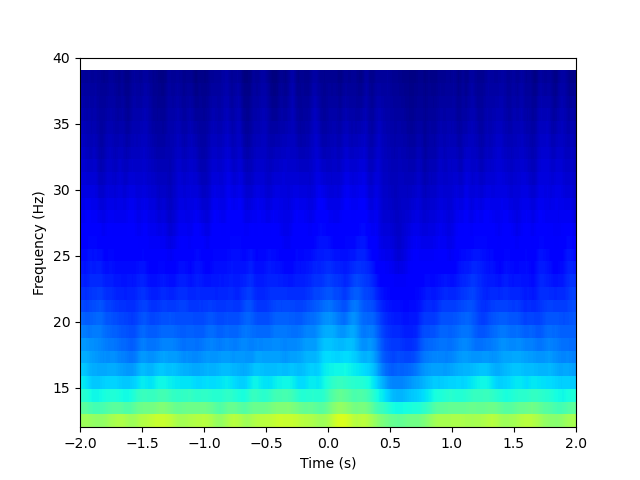

In [13]:
%matplotlib widget
plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

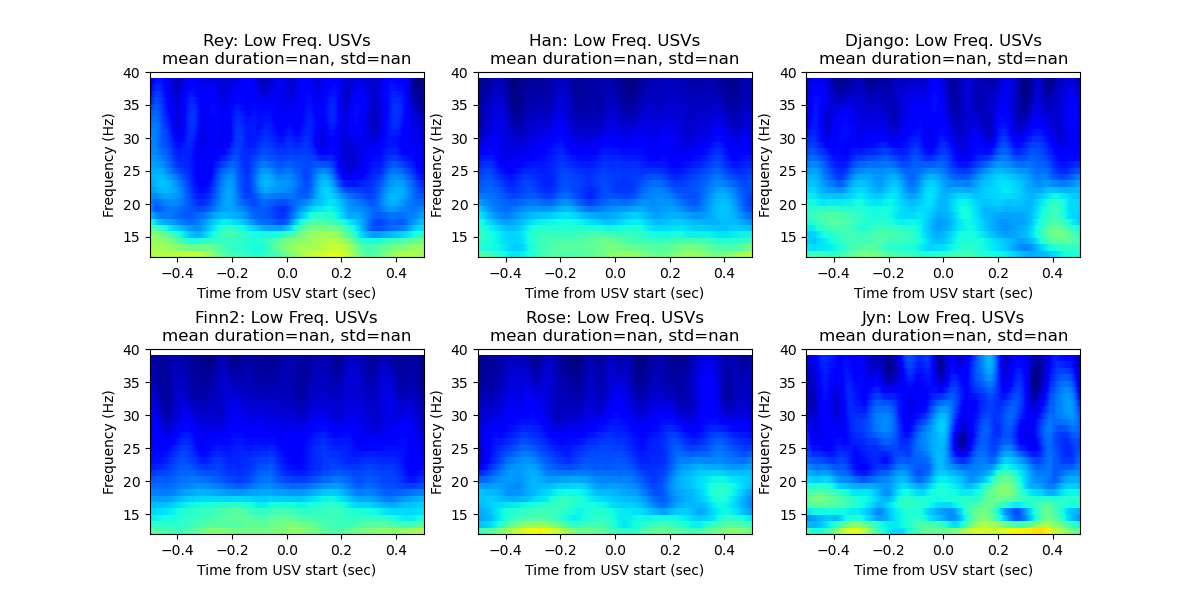

In [30]:
# Plot high USVs for all animals
%matplotlib widget
freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (0.5, 0.5)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > 25]
    if high_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                            ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV start (sec)')
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")
plt.subplots_adjust(hspace=0.5)

In [31]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_high_usv_onset.png')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

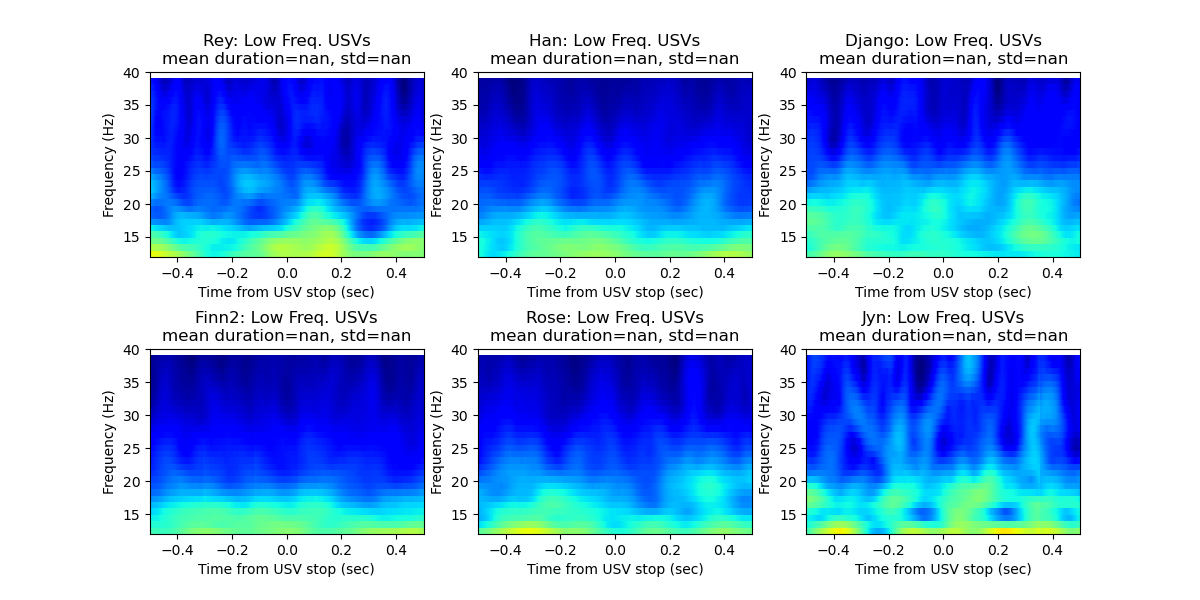

In [32]:
# Plot high USVs for all animals
%matplotlib widget
freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (0.5, 0.5)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > 25]
    if high_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(high_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                            ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")
plt.subplots_adjust(hspace=0.5)

In [33]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_high_usv_offset.png')

AttributeError: 'ProcessData' object has no attribute 'wv_delta'

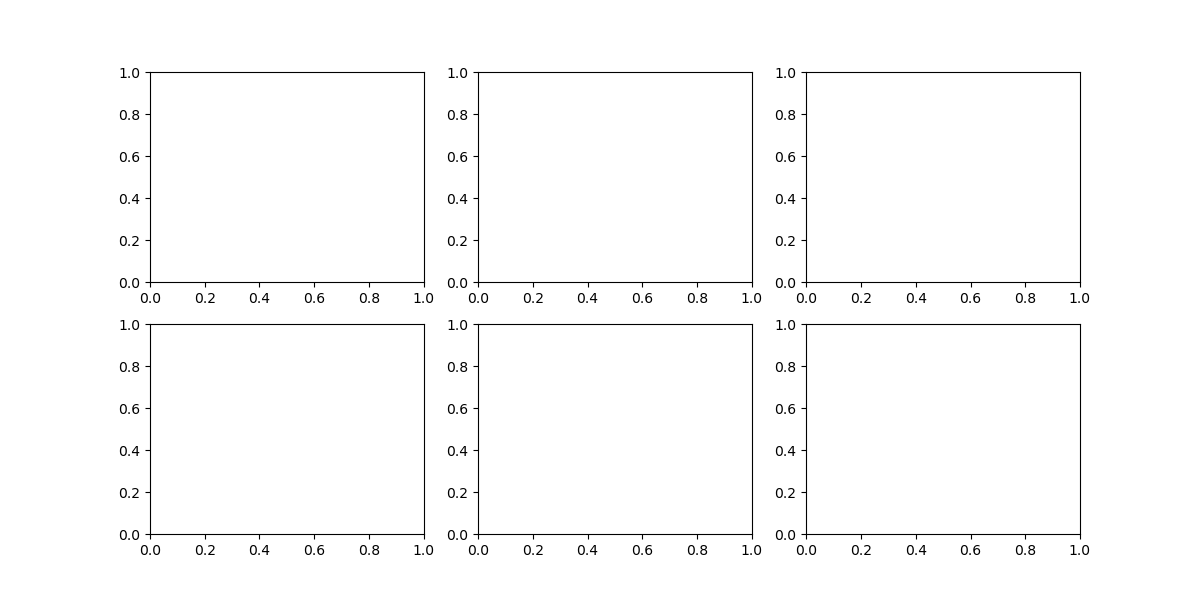

In [17]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (2, 2)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(low_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-2, 2)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')
        # Insert line break for title
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [ ]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_low_usv_offset.png')

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (2, 2)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
    
    if high_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-2, 2)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV start (sec)')

        title_text = f"{animal}: High Freq. USVs\nmean duration={high_usvs.Duration.mean():.3f}, std={high_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [ ]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_high_usv_onset.png')

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
beta_freq_lims = [12, 40]
usv_buffer_sec = (2, 2)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
    
    if high_usvs.shape[0] > 0:
        wv_beta_mean = sess.wv_beta.get_pe_mean_spec(high_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-2, 2)), freq_lims=beta_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')

        title_text = f"{animal}: High Freq. USVs\nmean duration={high_usvs.Duration.mean():.3f}, std={high_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [ ]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_beta_high_usv_offset.png')